In [110]:
%load_ext autoreload
%autoreload 2
import sys,os; sys.path.append(os.environ['BMESAHMETDIR']); import bmes #See bmes.ahmet/README.TXT for setting up BMESAHMETDIR environment variable.

#bmes.condainstall('h5py')
bmes.pipinstall(['tensorflow','keras','transformers','datasets','torch'])
import numpy as np

#Tensorflow currently (2023) supports only Nvidia GPU cards. If you have one, you may get x10-x100 times faster training.
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num GPUs Available:  0


In [111]:
#Dataset description can be found at: https://www.kaggle.com/datasets/kmader/mias-mammography
folder = bmes.kaggle_downloaddataset('kmader/mias-mammography') # This download may take some time to complete...
import pandas
d=pandas.read_csv(folder+'/info.txt',delim_whitespace=True);
d.head()

--- NOTICE: Kaggle dataset download folder [C:\Users\ahmet/Downloads/kmadermias-mammography] already exists.
    Remove that folder or set redownload=True if you wish to redownload the dataset [kmader/mias-mammography] there.


,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


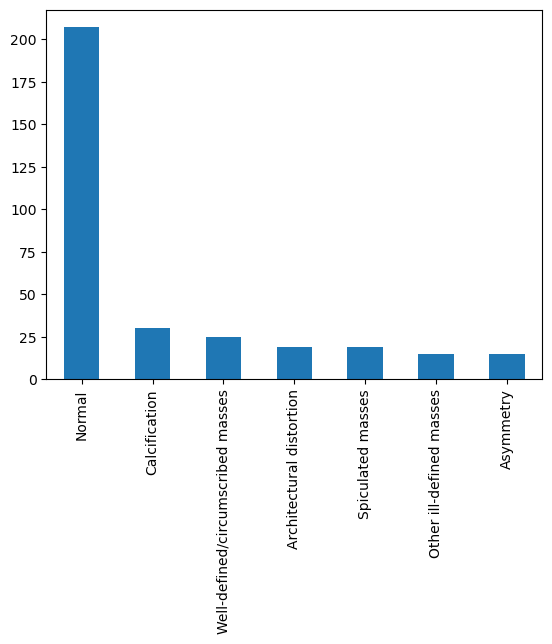

In [112]:
#replace the acronyms with more descriptive names.
d2=d.copy();
classdict={'CALC':'Calcification', 'CIRC':'Well-defined/circumscribed masses', 'SPIC':'Spiculated masses', 'MISC':'Other ill-defined masses', 'ARCH':'Architectural distortion','ASYM':'Asymmetry','NORM':'Normal'};
d2['CLASS']=[classdict[x] for x in d2['CLASS']]
d2['CLASS'].value_counts().plot(kind='bar');

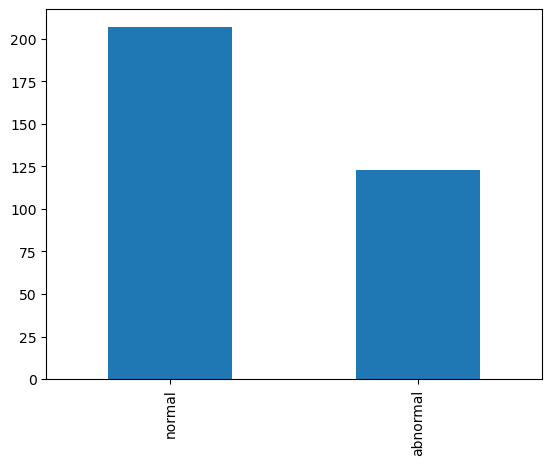

In [113]:
#I'll consider classification of normal (0) vs. abnormal (1). I'll consider any CLASS not labeled as NORM to be abnormal.
d['target'] = ['normal' if x == 'NORM' else 'abnormal' for x in d['CLASS']]
d['target'].value_counts().plot(kind='bar');

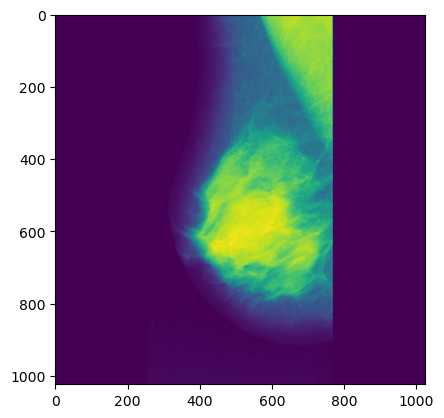

In [114]:
#show a sample image
from matplotlib import pyplot
from matplotlib.image import imread
imgfile = folder + '/all-mias/' + d.loc[0,'REFNUM']+'.pgm';
pyplot.imshow(imread(imgfile));

In [115]:
#Creating the following folder structure: --> NOT USED IN THE TENSORFLOW DATASET IMPLEMENTATION
"""
data/
    class_a/
		img1
		img2
        ...
    class_b/
		img1
		img2
        ...
"""
datafolder=folder + '/data';
if not bmes.isfolderandnotempty(datafolder):
    print('Copying images to new folder structure under [ %s ] ...'%(datafolder))
    bmes.mkdirif(datafolder)
    import shutil
    for i,r in d.iterrows():
        id=r['REFNUM'];
        imgfile = folder + '/all-mias/' + id +'.pgm';
        newimgfile = datafolder + '/' + r['target'] + '/' + id + '.pgm';
        bmes.mkfiledirif(newimgfile);
        shutil.copyfile(imgfile, newimgfile)

In [116]:
#Creating the following folder structure --> NOT USED IN THE TENSORFLOW DATASET IMPLEMENTATION
"""
traintestdata/
	train/
		class_a/
			img1
			img2
			...
		class_b/
			img1
			img2
			...
    test/
        ...  #similar subfolders as train/
	val/
        ...  #similar subfolders as train/
"""
ttdatafolder=folder+'/traintestdata';
if not bmes.isfolderandnotempty(ttdatafolder):
    print('Copying train/test images to new folder structure under [ %s ] ...'%(ttdatafolder))
    bmes.mkdirif(ttdatafolder)
    bmes.pipinstall('split-folders','splitfolders');
    import splitfolders
    splitfolders.ratio(datafolder, output=ttdatafolder, ratio=(.8,.1,.1))


In [117]:
# Convert .pgm to .jpg because tensorflow does not support .pgm images
jpgfolder=folder + '/all-mias.jpg';
if not bmes.isfolderandnotempty(jpgfolder):
    print('Converting images to .jpg format in [ %s ] ...'%(jpgfolder))
    bmes.mkdirif(jpgfolder)
    from PIL import Image
    for i,r in d.iterrows():
        id=r['REFNUM'];
        imgfile = folder + '/all-mias/' + id +'.pgm';
        newimgfile = jpgfolder + '/' + id + '.jpg';
        with Image.open(imgfile) as im: im.save(newimgfile)


In [118]:
# Create a tensorflow dataset.
# adapted from https://stackoverflow.com/questions/37340129/tensorflow-training-on-my-own-image
import tensorflow as tf
imgfiles=tf.constant([jpgfolder+'/'+ id +'.jpg' for id in d['REFNUM']]);
imglabels = tf.constant(d['target']);
#TODO: Keeping labels as strings creates problems later
# Until we find how to record classnames separately, let's keep them as numbers.
imglabels = [0 if x == 'normal' else 1 for x in imglabels]
class_names = ['normal', 'abnormal']

dataset = tf.data.Dataset.from_tensor_slices((imgfiles, imglabels))
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

dataset = dataset.map(_parse_function)

#dataset = dataset.batch(2)
#iter = dataset.__iter__();
#images, labels = next(iter)

dataset.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [119]:
# Split tensorflow dataset into training & testing:
# adapted from: https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
import tensorflow as tf
def tf_dataset_split(ds, ds_size=None, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    if ds_size==None: ds_size=int(tf.data.experimental.cardinality(ds));
    # Specify seed to always have the same split distribution between runs
    if shuffle: ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_dataorig, val_dataorig, test_dataorig = tf_dataset_split(dataset, train_split=0.8, test_split=0.1, val_split=0.1)

In [120]:
# Resize images to a size that works best with the pretrained model we are using.

#Adapted from: https://towardsdatascience.com/image-classification-transfer-learning-and-fine-tuning-using-tensorflow-a791baf9dbf3

# EfficientNetB0 works best with images of size (224, 224, 3), we'll use this function to apply to loaded images
def img_resize_224(image, label):
    image = tf.image.resize(image, size=(224,224))
    image = tf.cast(image, dtype = tf.float32)
    return image, label

train_data = train_dataorig.map(map_func=img_resize_224, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

#validation & test_data don't need to be shuffled
val_data = val_dataorig.map(map_func=img_resize_224, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_dataorig.map(map_func=img_resize_224, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data.element_spec, val_data.element_spec, test_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)))

In [121]:
# Performance tweak: Allow mix of float16 with float32, for performance benefits of float16 and numeric stability of float32
# https://towardsdatascience.com/image-classification-transfer-learning-and-fine-tuning-using-tensorflow-a791baf9dbf3
from tensorflow.keras import mixed_precision
if len(tf.config.list_physical_devices('GPU'))>0: mixed_precision.set_global_policy('mixed_float16')

In [122]:
# Callback function to save the best model.
def tensorboard_callback(directory, name):
    log_dir = directory + "/" + name
    t_c = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    return t_c

def model_checkpoint(directory, name):
    log_dir = directory + "/" + name
    m_c = tf.keras.callbacks.ModelCheckpoint(filepath=log_dir,
                                             monitor="val_accuracy",
                                             save_best_only=True,
                                             save_weights_only=True,
                                             verbose=1)
    return m_c

## Load a Pre-trained base_model and add layers for the current problem

In [146]:
# Load the pretrained model (will automatically download it if it hasn't downloaded before)
#base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False)
#base_model = tf.keras.applications.vgg16.VGG16(include_top=False)  #too slow.
#base_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
#base_model = tf.keras.applications.xception.Xception(include_top=False)
#EfficientNet is the fastest (Use B1, B2, etc. for more power and slower models)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
#base_model = tf.keras.applications.efficientnet.EfficientNetB4(include_top=False)
base_model.trainable = False


from tensorflow.keras import layers

inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name='poolingLayer')(x)

x = layers.Dense(10, name='myhiddenLayer')(x) #an optional hidden layer

x = layers.Dense(2, name='outputLayer')(x) #Number of units must match with the number of classes.
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

# We have a binary classification problem, so we could use 1 sigmoid unit
#x = layers.Dense(1, name='outputLayer')(x)
#outputs = layers.Activation(activation="sigmoid", dtype=tf.float32, name='activationLayer')(x)

model = tf.keras.Model(inputs, outputs, name = "FeatureExtractionModel")
print(model.summary()) #print a summary of the model

#print per-layer summary:
for lnum, layer in enumerate(model.layers): print(lnum, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

Model: "FeatureExtractionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 poolingLayer (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 myhiddenLayer (Dense)       (None, 10)                12810     
                                                                 
 outputLayer (Dense)         (None, 2)                 22        
                                                                 
 activationLayer (Activation  (None, 2)                0         
 )                                          

In [168]:
# Train the model
#use SparseCategoricalCrossentropy for multi-class problems and BinaryCrossentropy() for binary problems.
lossfunction = tf.keras.losses.SparseCategoricalCrossentropy()
#lossfunction = tf.keras.losses.BinaryCrossentropy() #this requires that there be a single output unit.

base_model.trainable = False
model.compile(loss = lossfunction,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

hist_model = model.fit(train_data,
    epochs = 5,
    steps_per_epoch=len(train_data),
    validation_data=val_data,
    validation_steps=int(0.1 * len(val_data)),
    callbacks=[tensorboard_callback(folder,"model"),model_checkpoint("Checkpoints","model.ckpt")])

Epoch 1/5
9/9 [==============================] - 22s 1s/step - loss: 0.4306 - accuracy: 0.8258
Epoch 2/5
9/9 [==============================] - 10s 1s/step - loss: 0.4312 - accuracy: 0.8182
Epoch 3/5
9/9 [==============================] - 8s 794ms/step - loss: 0.4094 - accuracy: 0.8258
Epoch 4/5
9/9 [==============================] - 9s 976ms/step - loss: 0.3845 - accuracy: 0.8598
Epoch 5/5
9/9 [==============================] - 10s 1s/step - loss: 0.3733 - accuracy: 0.8636


In [169]:
model_results = model.evaluate(test_data)

2/2 [==============================] - 4s 92ms/step - loss: 0.3248 - accuracy: 0.9091


In [170]:
# Optional: Fine-tune the base model, but not the input normalization
base_model.trainable = True
for layer in model.layers[1].layers:
    if isinstance(layer, layers.BatchNormalization): layer.trainable = False

#Reduce the learning rate, so we don't mess up the base model too much.
model.compile(loss = lossfunction,
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ["accuracy"])
hist_model_tuned = model.fit(train_data,
                             epochs=5,
                             steps_per_epoch=len(train_data),
                             validation_data=val_data,
                             validation_steps=int(0.1*len(val_data)),
                             initial_epoch=hist_model.epoch[-1],
                             callbacks=[tensorboard_callback(folder, "model_tuned"), model_checkpoint("Checkpoints", "model_tuned.ckpt")])        

Epoch 5/5
9/9 [==============================] - 48s 4s/step - loss: 0.6242 - accuracy: 0.6780


In [171]:
model_tuned_results = model.evaluate(test_data)

2/2 [==============================] - 3s 76ms/step - loss: 0.7796 - accuracy: 0.6970


In [172]:
preds = model.predict(test_data, verbose = 1)
pred_labels = tf.argmax(preds, axis=1)
pred_labels[:10]

2/2 [==============================] - 3s 71ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 0, 1, 1, 0, 0, 0, 1, 0, 0], dtype=int64)>

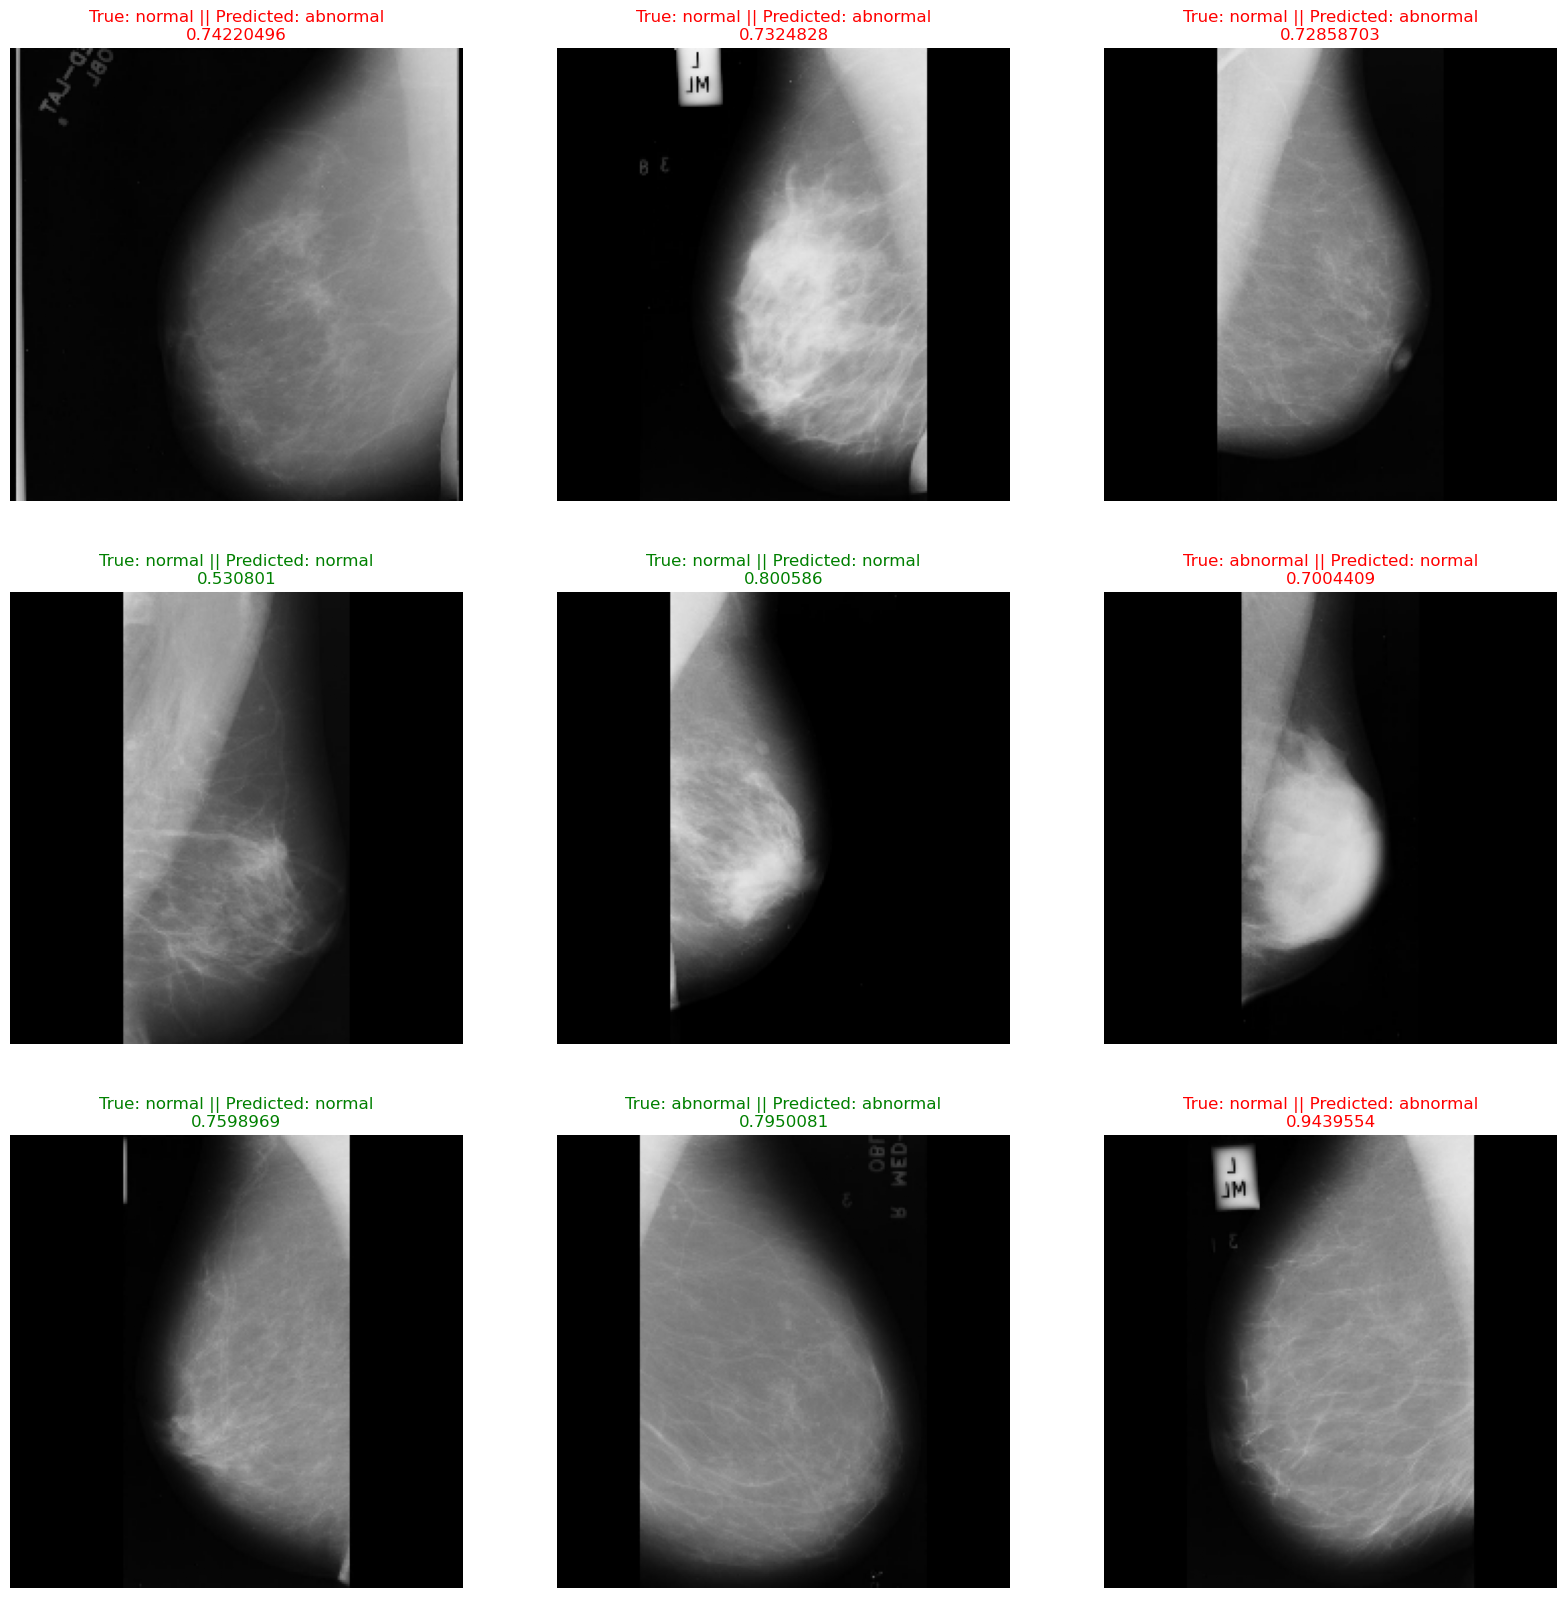

In [173]:
# Test on a few example test images and show the results.
test_labels = np.concatenate([label for image,label in test_data])
test_image_batches = [images.numpy() for images, labels in test_data.take(-1)]
#test_images = [item for sublist in test_image_batches for item in sublist]
test_images = [item for sublist in test_image_batches for item in sublist]

import matplotlib.pyplot as plt
import random, math

numexamples = min(9,len(test_images));
numperrow = 3;
Isubset = random.sample(range(len(test_images)),numexamples);
plt.figure(figsize = (20,20))
for i in range(numexamples):
    testind = Isubset[i];
    plt.subplot(math.ceil(numexamples/numperrow),numperrow,i+1)
    #I was expecting to have color images in test_images, but this shows in grayscale. If you find out why and where to fix that, let me know.
    plt.imshow(test_images[testind]/255.)
    color = 'g' if test_labels[testind] == pred_labels[testind] else 'r'
    plt.title("True: " + class_names[test_labels[testind]] + " || " + "Predicted: " +
              class_names[pred_labels[testind]] + "\n" + 
              str(np.asarray(tf.reduce_max(preds, axis = 1))[testind]), c=color)
    plt.axis(False);